### Import packages

In [77]:
import pickle
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from statistics import mode
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import glob 
import os
import json
from matplotlib.colors import LogNorm
import math

In [78]:
#root_folder_path = "N:\\durable\\sound-and-ecg\\2024-10-Maja-restructured\\Data"
root_folder_path = "C:\\Users\\MajaE\\src\\repos\\master_ML\\Data"

### Extract data

In [79]:
def post_processing(true, predictions, predictions_proba, segment_size):
    # Find number of observations in the data
    segmented_true = []
    segmented_predictions = []
    segmented_predictions_proba = []

    for i in range(len(true)):
        subject_segmented_true = []
        subject_segmented_predictions = []
        subject_segmented_predictions_proba = []
        for j in range(0,len(true[i])-segment_size):
            # Majority voting for the separate segments
            subsequence_true = int(mode(true[i][j:(j+segment_size)]))
            subsequence_predictions = int(mode(predictions[i][j:(j+segment_size)]))
            subsequence_predictions_proba = round(np.mean(predictions_proba[i][j:(j+segment_size)]))
            subject_segmented_true.append(subsequence_true)
            subject_segmented_predictions.append(subsequence_predictions)
            subject_segmented_predictions_proba.append(subsequence_predictions_proba)
        segmented_true.append(subject_segmented_true)
        segmented_predictions.append(subject_segmented_predictions)
        segmented_predictions_proba.append(subject_segmented_predictions_proba)
    return segmented_true,segmented_predictions, segmented_predictions_proba

In [80]:
def extract_test_parameters(test_file):
    true,predictions,predictions_proba,test_recording_ids,segment_parameters =[],[],[],[],[]
    with open(test_file, 'rb') as handle:
        true,predictions,predictions_proba,test_recording_ids, segment_parameters = pickle.load(handle)
    if segment_parameters[2] == 1:
        true, predictions, predictions_proba = post_processing(true,predictions,predictions_proba,30)
        segment_parameters[2] = 30
    return true,predictions,predictions_proba,test_recording_ids,segment_parameters

### Analyze metrics

In [81]:
def calculate_metrics(true,predictions):
    accuracy = accuracy_score(true, predictions) # ((TN + TP) / (TN + FN + TP + FP))
    f1 = f1_score(true,predictions,zero_division=np.nan,average='macro')
    return accuracy,f1

### Plot ROC curve

In [82]:
def find_avg_performance(folder_path):
    test_files = glob.glob(os.path.join(folder_path,'*.pickle'))
    true, predictions, predictions_proba, ids, segment_parameters = [], [], [], [], []
    for test_file in test_files:
        true_subject, predictions_subject,predictions_proba_subject,test_recording_ids,segment_parameters_subject = extract_test_parameters(test_file)
        true.extend(true_subject)
        predictions.extend(predictions_subject)
        predictions_proba.extend(predictions_proba_subject)
        ids.extend(test_recording_ids)
        segment_parameters.extend([segment_parameters_subject])
    accuracy_vector, f1_vector = [], []
    for subject_idx in range(len(true)):
        accuracy,f1 = calculate_metrics(true[subject_idx],predictions[subject_idx])
        accuracy_vector.append(accuracy)
        f1_vector.append(f1)
    accuracy = np.nanmean(accuracy_vector)
    f1 = np.nanmean(f1_vector)
    return accuracy, f1

In [83]:
def feature_selection_performance(root_folder_path):
    accuracy = []
    f1 = []
    run_folder_path = root_folder_path
    for run in os.listdir(root_folder_path):
        run_accuracy = []
        run_f1 = []
        run_folder_path = os.path.join(root_folder_path,run)
        data_folder_path = os.path.join(run_folder_path,"data")
        for iteration in os.listdir(data_folder_path):
            iteration_path = os.path.join(data_folder_path,iteration)
            i_accuracy, i_f1 = find_avg_performance(iteration_path)
            run_accuracy.append(i_accuracy)
            run_f1.append(i_f1)
        accuracy.append(run_accuracy)
        f1.append(run_f1)
    
    avg_accuracy = []
    avg_f1 = []
    std_accuracy = []
    std_f1 = []
    n_runs = len(accuracy)
    n_features = len(accuracy[0])
    for i in range (n_features):
        acc_sum = 0
        f1_sum = 0
        for j in range (n_runs):
            acc_sum += accuracy[j][i]
            f1_sum += f1[j][i]
        mean_acc = acc_sum/n_runs
        mean_f1 = f1_sum/n_runs
        avg_accuracy.append(mean_acc)
        avg_f1.append(mean_f1)

        variance_acc = sum((accuracy[j][i] - mean_acc) ** 2 for j in range(n_runs)) / n_runs
        std_acc = math.sqrt(variance_acc)
        std_accuracy.append(std_acc)
        variance_f1 = sum((f1[j][i] - mean_f1) ** 2 for j in range(n_runs)) / n_runs
        std_feature_f1 = math.sqrt(variance_f1)
        std_f1.append(std_feature_f1)

    parameters_path = f"{run_folder_path}\\parameters.json"
    test_values = []
    with open(parameters_path, 'r') as file:
        meta_data = json.load(file)
        test_values = meta_data["test_values"]
    
    return avg_accuracy, avg_f1, std_accuracy, std_f1, test_values


In [84]:
def feature_selection_curve(selection_algorithms,label):
    accuracies, f1_scores, std_accuracies, std_f1_scores, n_features_vec = [], [], [], [], []
    for selection_algorithm in selection_algorithms:
        accuracy, f1, std_accuracy, std_f1, n_features = feature_selection_performance(selection_algorithm)
        accuracies.append(accuracy)
        f1_scores.append(f1)
        n_features_vec.append(n_features) 
        std_accuracies.append(std_accuracy)
        std_f1_scores.append(std_f1)

    plt.figure()
    for idx in range (len(accuracies)):
        acc = np.array(accuracies[idx])
        std = np.array(std_accuracies[idx])
        n_features = np.array(n_features_vec[idx])
        line, = plt.plot(n_features,acc,label=selection_algorithms[idx])
        plt.fill_between(n_features,acc-std,acc+std,color=line.get_color(), alpha = 0.2)
    plt.xlabel('Number of selected features')
    plt.ylabel('Accuracy')
    plt.title(f'Performance of {label}')
    plt.legend()
    plt.grid(True)
    plt.show()

    plt.figure()
    for idx in range (len(f1_scores)):
        f1 = np.array(f1_scores[idx])
        std = np.array(std_f1_scores[idx])
        n_features = np.array(n_features_vec[idx])
        line, = plt.plot(n_features,f1,label=selection_algorithms[idx])
        plt.fill_between(n_features,f1-std,f1+std,color=line.get_color(), alpha = 0.2)
    plt.xlabel('Number of selected features')
    plt.ylabel('F1')
    plt.title(f'Performance of {label}')
    plt.legend()
    plt.grid(True)
    plt.show()

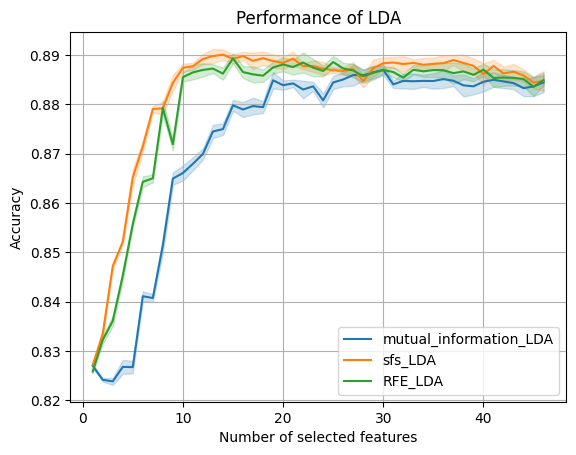

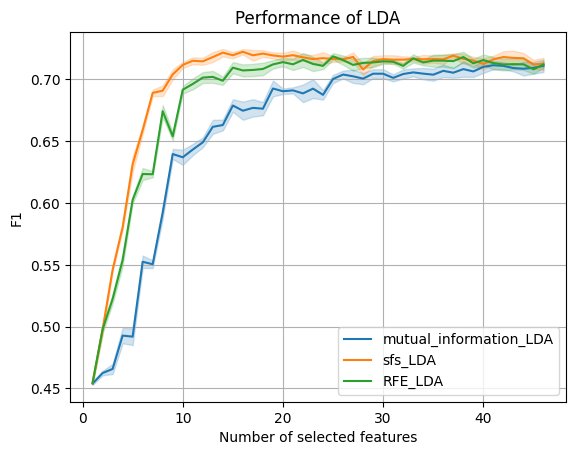

In [85]:
classes = ['No meal','Meal']
selection_algorithms = ["mutual_information_LDA","sfs_LDA","RFE_LDA"]
#selection_algorithms = ["mutual_information_HMM","sfs_HMM"]
feature_selection_curve(selection_algorithms,'LDA')

In [86]:
importance_mutual_information, importance_sfs = [],[]
# Extract features from previous calculations
with open(f'..\\feature_selection_HMM.pickle', 'rb') as handle:
    importance_mutual_information, importance_sfs = pickle.load(handle)

values = list(range(1,23+1))
indices_list = np.where(np.isin(importance_sfs,values))[0]
print(indices_list)

# with open(f'..\\selected_features_HMM.pickle','wb') as handle:
#     pickle.dump([indices_list],handle,protocol=pickle.HIGHEST_PROTOCOL)


[ 1  4  7  8  9 12 14 15 18 19 21 23 24 26 28 30 32 34 37 40 41 42 44]


In [87]:
selected_features_idx = []
with open(f'..\\selected_features_LDA.pickle','rb') as handle:
    selected_features_idx = pickle.load(handle)[0]

print(selected_features_idx)

[ 0  1  3  5  8 10 13 14 19 20 28 42]
